In [2]:
import numpy as np
from numpy.random import rand
import matplotlib.pyplot as plt
import numba 
from numba import jit,njit
from scipy.ndimage import convolve, generate_binary_structure

In [3]:
lattice_size = [10,12,14,16]

def lattice(N):
 return 2*np.random.randint(2,size=(N,N))-1 

lattice1 = lattice(lattice_size[0])
lattice2 = lattice(lattice_size[1])
lattice3 = lattice(lattice_size[2])
lattice4 = lattice(lattice_size[3])



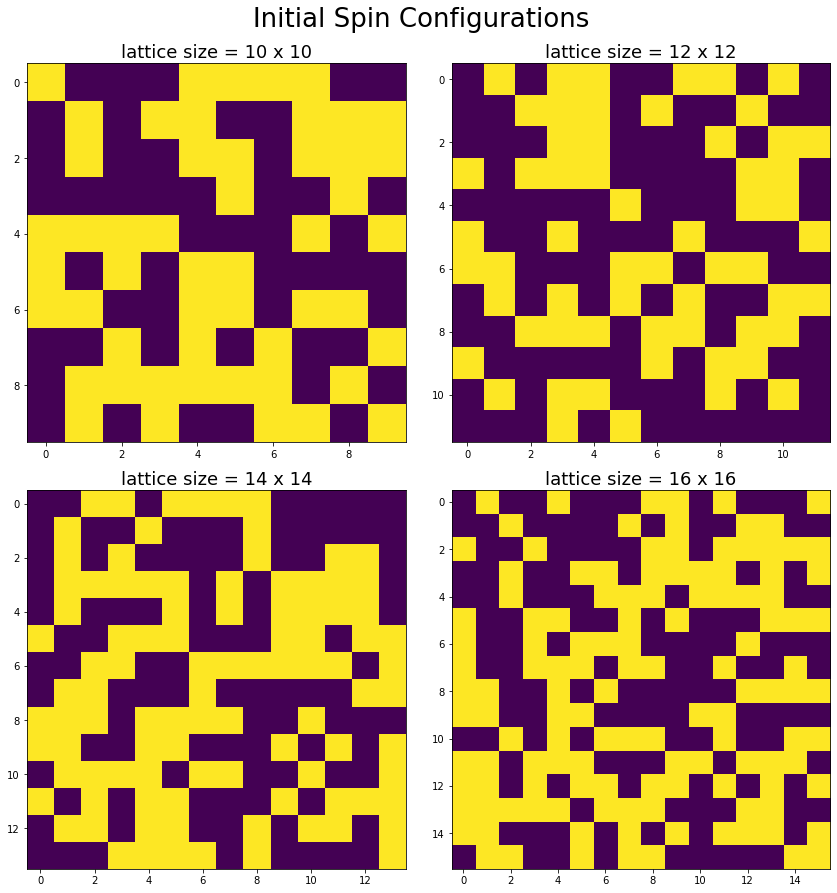

In [4]:
fig,axes = plt.subplots(2,2,figsize=(12,12))

ax=axes[0,0]
ax.imshow(lattice1)
ax.set_title(f'lattice size = {lattice_size[0]} x {lattice_size[0]}',fontsize=18)
ax=axes[0,1]
ax.imshow(lattice2)
ax.set_title(f'lattice size = {lattice_size[1]} x {lattice_size[1]}',fontsize=18)
ax=axes[1,0]
ax.imshow(lattice3)
ax.set_title(f'lattice size = {lattice_size[2]} x {lattice_size[2]}',fontsize=18)
ax=axes[1,1]
ax.imshow(lattice4)
ax.set_title(f'lattice size = {lattice_size[3]} x {lattice_size[3]}',fontsize=18)
fig.tight_layout()
fig.suptitle(r'Initial Spin Configurations', y=1.03, size=26)
plt.show()

In [5]:
nt = 50           # number of temperature points
eqsteps = 2000     # number of MC sweeps for equilibration
mcsteps = 1000     # number of MC sweeps for calculation

Temperature = np.linspace(1.53, 3.28, nt)
Energy, Magnetization, SpecificHeat, Susceptibility = np.zeros((4,nt)), np.zeros((4,nt)), np.zeros((4,nt)), np.zeros((4,nt))
# n=1/(mcsteps*N*N)

In [6]:
Temperature

array([1.53      , 1.56571429, 1.60142857, 1.63714286, 1.67285714,
       1.70857143, 1.74428571, 1.78      , 1.81571429, 1.85142857,
       1.88714286, 1.92285714, 1.95857143, 1.99428571, 2.03      ,
       2.06571429, 2.10142857, 2.13714286, 2.17285714, 2.20857143,
       2.24428571, 2.28      , 2.31571429, 2.35142857, 2.38714286,
       2.42285714, 2.45857143, 2.49428571, 2.53      , 2.56571429,
       2.60142857, 2.63714286, 2.67285714, 2.70857143, 2.74428571,
       2.78      , 2.81571429, 2.85142857, 2.88714286, 2.92285714,
       2.95857143, 2.99428571, 3.03      , 3.06571429, 3.10142857,
       3.13714286, 3.17285714, 3.20857143, 3.24428571, 3.28      ])

In [7]:
# @jit(nopython=True)
def mcmove(state, beta):
    N = np.shape(state)[0]
    for i in range(N):
        for j in range(N):
                a = np.random.randint(0, N)
                b = np.random.randint(0, N)
                sig_i =  state[a, b]
                sig_j = state[(a+1)%N,b] + state[(a-1)%N,b] + state[a,(b+1)%N] + state[a,(b-1)%N]
                delta_E = 2*sig_i*sig_j

                if delta_E <0:
                  sig_i *= -1
                elif rand() < np.exp(-delta_E*Beta):
                  sig_i *= -1
                state[a,b] = sig_i
    return state

# @jit(nopython=True)
def calcEnergy(config):

    energy = 0 
    N = np.shape(config)[0]
    for i in range(len(config)):
        for j in range(len(config)):
            S = config[i,j]
            nb = config[(i+1)%N, j] + config[i,(j+1)%N] + config[(i-1)%N, j] + config[i,(j-1)%N]
            energy += -nb*S
    return energy/2


# @jit(nopython=True)
def calcMag(config):
    mag = np.sum(config)
    return mag

In [8]:
for item in range(len(lattice_size)):
  if item == 0:
    state = lattice1
  elif item == 1:
    state = lattice2
  elif item == 2:
    state = lattice3
  else:
    state = lattice4
  
  n = np.shape(state)[0]
  for t in range(nt):
    E=M=0
    Beta = 1/Temperature[t]

    for i in range(eqsteps):
      mcmove(state, Beta)
    
    for i in range(mcsteps):
      mcmove(state, Beta)
      E += calcEnergy(state)
      M += abs(calcMag(state))
    
    Energy[item,t] = E/(mcsteps*n*n)
    Magnetization[item,t] = M/(mcsteps*n*n)
    

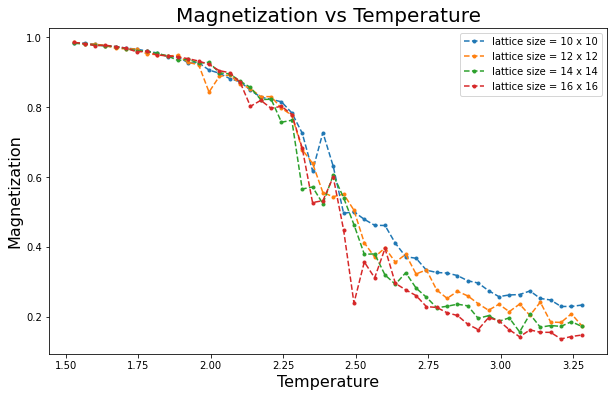

In [9]:
plt.figure(figsize=(10,6))
plt.plot(Temperature,Magnetization[0],'.--',label =f'lattice size = {lattice_size[0]} x {lattice_size[0]}')
plt.plot(Temperature,Magnetization[1],'.--',label =f'lattice size = {lattice_size[1]} x {lattice_size[1]}')
plt.plot(Temperature,Magnetization[2],'.--',label =f'lattice size = {lattice_size[2]} x {lattice_size[2]}')
plt.plot(Temperature,Magnetization[3],'.--',label =f'lattice size = {lattice_size[3]} x {lattice_size[3]}')
plt.title('Magnetization vs Temperature',fontsize=20)
plt.xlabel('Temperature',fontsize=16)
plt.ylabel('Magnetization',fontsize=16)
plt.legend()
plt.show()

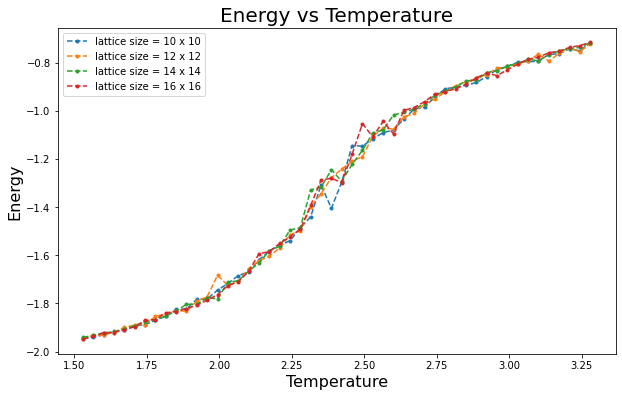

In [10]:
plt.figure(figsize=(10,6))
plt.plot(Temperature,Energy[0],'.--',label =f'lattice size = {lattice_size[0]} x {lattice_size[0]}')
plt.plot(Temperature,Energy[1],'.--',label =f'lattice size = {lattice_size[1]} x {lattice_size[1]}')
plt.plot(Temperature,Energy[2],'.--',label =f'lattice size = {lattice_size[2]} x {lattice_size[2]}')
plt.plot(Temperature,Energy[3],'.--',label =f'lattice size = {lattice_size[3]} x {lattice_size[3]}')
plt.title('Energy vs Temperature',fontsize=20)
plt.xlabel('Temperature',fontsize=16)
plt.ylabel('Energy',fontsize=16)
plt.legend()
plt.show()

In [11]:
np.shape(config)[0]

NameError: ignored

In [ ]:
np.random.randint(0, 50)